**To access the folders from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**Navigating to the parent directory**

In [ ]:
%cd /content/gdrive/My\ Drive/MTEYolov5

/content/gdrive/My Drive/MTEYolov5


**Ultralytics Yolov5 Repository**

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9829, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9829 (delta 1), reused 4 (delta 0), pack-reused 9820
Receiving objects: 100% (9829/9829), 10.22 MiB | 6.58 MiB/s, done.
Resolving deltas: 100% (6796/6796), done.


**Installing necessary requirements**

In [ ]:
!pip install -r yolov5/requirements.txt

     |████████████████████████████████| 596 kB 13.1 MB/s            
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Importing all required models**

In [ ]:
import torch #Yolov5 is a Pytorch implementation
from IPython.display import Image  # for displaying output images
import os 
import random
import shutil # helps perform file operations
from sklearn.model_selection import train_test_split # to split dataset into train, validation and testing sections
import xml.etree.ElementTree as ET # to access information from XML annotations and convert to YOLO Format annotations
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt # To plot images

random.seed(0)

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.9.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [ ]:
%cd '/content/gdrive/My Drive/MTEYolov5/'
%cd phone_Dataset/phone #Dataset Folder

/content/gdrive/My Drive/MTEYolov5
/content/gdrive/My Drive/MTEYolov5/phone_Dataset/phone


**Weights & Biases (WandB) is a python package that allows us to monitor our training in real-time. It can be easily integrated with popular deep learning frameworks like Pytorch, Tensorflow, or Keras.**

In [ ]:
# Setup wandb
!pip install wandb

     |████████████████████████████████| 1.7 MB 11.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 180 kB 48.2 MB/s            
     |████████████████████████████████| 139 kB 53.1 MB/s            
     |████████████████████████████████| 97 kB 6.8 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 63 kB 1.7 MB/s             
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=4a539adeffc2c0c22effb6c61cbb101ec09dfc46f214d8b77fd48906ba709eef
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=43a2d87d4284bc16d9e34c480f24614939354cb0b4a1d80b569f85cc1ee857fc
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


**Sample XML Annotation**

In [ ]:
! cat annotations/img_102064.xml

<annotation>
	<folder>new images</folder>
	<filename>img_102064.jpg</filename>
	<path>/Users/sajalaggarwal/Desktop/phone-transfer-learning/phone/new images/img_102064.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>640</width>
		<height>480</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>phone</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>350</xmin>
			<ymin>231</ymin>
			<xmax>421</xmax>
			<ymax>274</ymax>
		</bndbox>
	</object>
</annotation>


**Function to get the data from XML Annotation**

In [ ]:
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialising the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parsing the XML Tree
    for elem in root:
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict
    

In [ ]:
print(extract_info_from_xml('annotations/img_102064.xml'))

{'bboxes': [{'class': 'phone', 'xmin': 350, 'ymin': 231, 'xmax': 421, 'ymax': 274}], 'filename': 'img_102064.jpg', 'image_size': (640, 480, 3)}


**Converting XML Annotations to the format accepted by YOLO**

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"phone": 0,}


def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transforming the bbox co-ordinates as per the format required by YOLO algorithm
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalisation of the co-ordinates by dividing by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
      
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("jpg", "txt"))
    
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

**Converting and saving the annotations**

In [ ]:
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 572/572 [06:44<00:00,  1.41it/s]


{0: 'phone'}
images/img_87172.jpg


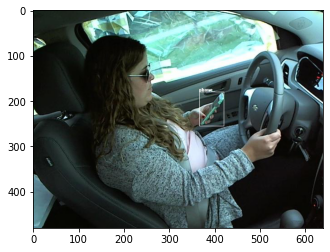

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
print(class_id_to_name_mapping)

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()


annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]


image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)


image = Image.open(image_file)

plot_bounding_box(image, annotation_list)


**Splitting the dataset into train-valid-test splits (80% images are used for training, 10% for validation and 10% for testing)**

In [ ]:
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


**Making the folders to store training and validation portions**

In [ ]:
!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

**Moving the split images into respective folders using shutil**

In [ ]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False


move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [ ]:
%mv annotations labels
%cd ../../yolov5 

mv: cannot stat 'annotations': No such file or directory
/content/gdrive/My Drive/MTEYolov5/yolov5


In [ ]:
!cat data/phone_data.yaml

train: ../phone/phone_Dataset/images/train/ 
val:  ../phone/phone_Dataset/images/val/
test: ../phone/phone_Dataset/images/test/

# number of classes
nc: 1

# class names
names: ["phone"]

**Training the model for 100 epochs**
Optimiser: Stochastic Gradient Descent
and Loss calculation: Binary cross entropy with logits loss


In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 
--data phone_data.yaml --weights yolov5s.pt --workers 24 --name yolo_phone

wandb: Currently logged in as: sajal-aggarwal (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=phone_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_phone, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 2021-11-3 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0

In [ ]:
!python detect.py --source ../phone_Dataset/phone/images/test/ --weights '/content/gdrive/MyDrive/MTEYolov5/yolov5/runs/train/yolo_phone2/weights/best.pt' --conf 0.25 --name yolo_phone2

detect: weights=['/content/gdrive/MyDrive/MTEYolov5/yolov5/runs/train/yolo_phone2/weights/best.pt'], source=../phone_Dataset/phone/images/test/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_phone2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2021-11-3 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/58 /content/gdrive/MyDrive/MTEYolov5/phone_Dataset/phone/images/test/img_100006.jpg: 480x640 1 phone, Done. (0.022s)
image 2/58 /content/gdrive/MyDrive/MTEYolov5/phone_Dataset/phone/images/test/img_100419.jpg: 480x640 1 phone, Done. (0.020s)
image 3/58 /content/gdrive/MyDrive/MTEYolov5/phone_Dataset/phone/images/test/im

**Detection on images**

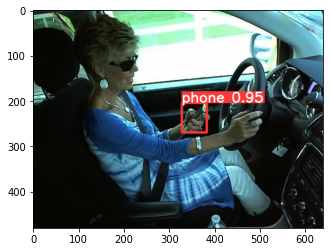

In [ ]:
detections_dir = "runs/detect/yolo_phone2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

**Detection on a sample 24 FPS video**

In [ ]:
!python detect.py --source IMG_3300.MOV --weights '/content/gdrive/MyDrive/MTEYolov5/yolov5/runs/train/yolo_phone2/weights/best.pt' --conf 0.25 --name yolo_phone2

detect: weights=['/content/gdrive/MyDrive/MTEYolov5/yolov5/runs/train/yolo_phone2/weights/best.pt'], source=IMG_3300.MOV, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_phone2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2021-11-3 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/181) /content/gdrive/MyDrive/MTEYolov5/yolov5/IMG_3300.MOV: 384x640 Done. (0.029s)
video 1/1 (2/181) /content/gdrive/MyDrive/MTEYolov5/yolov5/IMG_3300.MOV: 384x640 Done. (0.027s)
video 1/1 (3/181) /content/gdrive/MyDrive/MTEYolov5/yolov5/IMG_3300.MOV: 384x640 Done. (0.028s)
video 1/1 (4/181) /content/gdrive/MyDrive/MTEYolov5/yolov5/IMG_3